<a href="https://colab.research.google.com/github/Sevenc1over/AI-class/blob/main/WISDM/WISDM_CNN%2BGRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [158]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, Conv1D, MaxPooling1D, Input, BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical


In [159]:
df = pd.read_csv('/content/drive/MyDrive/WISDM.csv', header=None)
df.columns = ['idx', 'user_id', 'activity', 'timestep', 'x_axis', 'y_axis', 'z_axis']
display(df.head())

,idx,user_id,activity,timestep,x_axis,y_axis,z_axis
0,0,33,Jogging,4.910600e+13,-0.694638,12.680544,0.503953
1,1,33,Jogging,4.910610e+13,5.012288,11.264028,0.953424
2,2,33,Jogging,4.910610e+13,4.903325,10.882658,-0.081722
3,3,33,Jogging,4.910620e+13,-0.612916,18.496431,3.023717
4,4,33,Jogging,4.910630e+13,-1.184970,12.108489,7.205164


특징 추출

In [160]:
features = ['x_axis', 'y_axis', 'z_axis']

data = df[features].values
labels = df['activity'].values

슬라이딩 윈도우  



이를 이용해 시간적 특징을 유지하고자 했습니다


In [161]:
def sliding_window(data, labels, window_size=100, step_size=50):
    X = []
    y = []

    for start in range(0, len(data) - window_size + 1, step_size):
        end = start + window_size

        window_data = data[start:end]

        window_label = labels[end - 1] #윈도우 라벨을 뒷쪽 라벨로 결정.(2개로 나누어져있다면.)

        X.append(window_data)
        y.append(window_label)

    return np.array(X), np.array(y)

In [162]:
window_size = 100
step_size = 50

X_windows, y_windows = sliding_window(data, labels, window_size, step_size)

print("X_windows shape:", X_windows.shape)
print("y_windows shape:", y_windows.shape)

X_windows shape: (20970, 100, 3)
y_windows shape: (20970,)


In [163]:
y_onehot = pd.get_dummies(y_windows).astype(int).values
print(y_onehot)

[[0 1 0 0 0 0]
 [0 1 0 0 0 0]
 [0 1 0 0 0 0]
 ...
 [0 0 0 1 0 0]
 [0 0 0 1 0 0]
 [0 0 0 1 0 0]]


In [164]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_windows, y_onehot, test_size=0.3, shuffle=False)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, shuffle=False)

In [165]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()

X_train_scaled = scaler.fit_transform(df[['x_axis','y_axis','z_axis']])
X_test_scaled = scaler.transform(df[['x_axis','y_axis','z_axis']])
X_val_scaled = scaler.transform(df[['x_axis','y_axis','z_axis']])

In [166]:
df['activity'].unique()

array(['Jogging', 'Walking', 'Upstairs', 'Downstairs', 'Sitting',
       'Standing'], dtype=object)

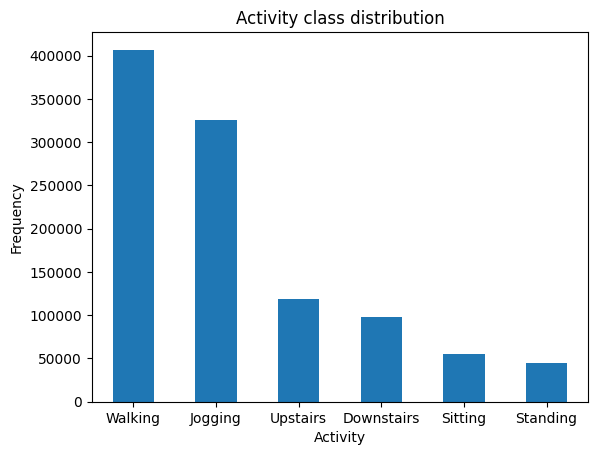

In [167]:
count_classes = df['activity'].value_counts(sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Activity class distribution")
plt.xlabel("Activity")
plt.ylabel("Frequency");

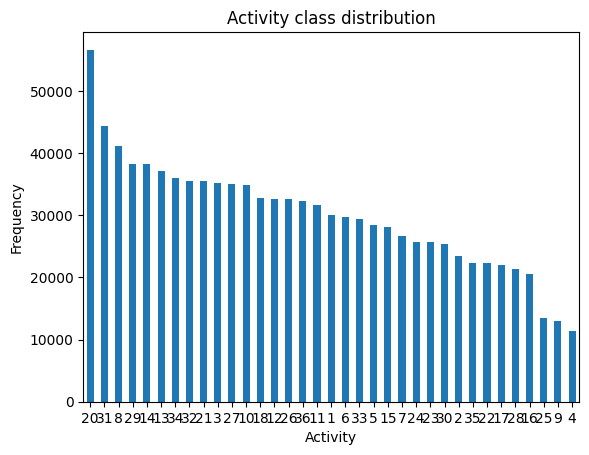

In [168]:
count_classes = df['user_id'].value_counts(sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Activity class distribution")
plt.xlabel("Activity")
plt.ylabel("Frequency");

In [169]:
df.shape

(1048575, 7)

In [170]:
#각 activity별로 데이터 shape 분류
Walking = df[df['activity'] == 'Walking']
Jogging = df[df['activity'] == 'Jogging']
Upstairs = df[df['activity'] == 'Upstairs']
Downstairs = df[df['activity'] == 'Downstairs']
Sitting = df[df['activity'] == 'Sitting']
Standing = df[df['activity'] == 'Standing']
print(f"Jogging data shape: {Jogging.shape}")
print(f"Walking data shape: {Walking.shape}")
print(f"Upstairs data shape: {Upstairs.shape}")
print(f"Downstairs data shape: {Downstairs.shape}")
print(f"Sitting data shape: {Sitting.shape}")
print(f"Standing data shape: {Standing.shape}")

Jogging data shape: (325975, 7)
Walking data shape: (406775, 7)
Upstairs data shape: (118589, 7)
Downstairs data shape: (97813, 7)
Sitting data shape: (54876, 7)
Standing data shape: (44547, 7)


In [171]:
data = df.drop(['idx','user_id', 'timestep'], axis=1)
data.shape

(1048575, 4)

모델 생성

In [172]:
model = Sequential([
    Input(shape=(100, 3)),

    Conv1D(64, kernel_size=5, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Conv1D(128, kernel_size=5, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    GRU(64, return_sequences=True),
    BatchNormalization(),

    GRU(32, return_sequences=False),
    BatchNormalization(),
    Dropout(0.5),


    Dense(64, activation='relu'),
    Dropout(0.4),

    Dense(6, activation='softmax')
])

In [173]:
#모델 컴파일하기
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [174]:
model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_22 (Conv1D)              │ (None, 100, 64)        │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_39          │ (None, 100, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_22 (MaxPooling1D) │ (None, 50, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_23 (Conv1D)              │ (None, 50, 128)        │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_40          │ (None, 50, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_23 (MaxPooling1D) │ (None, 25, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_25 (GRU)                    │ (None, 25, 64)         │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_41          │ (None, 25, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_26 (GRU)                    │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_42          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 92,422 (361.02 KB)

 Trainable params: 91,846 (358.77 KB)

 Non-trainable params: 576 (2.25 KB)

In [175]:
model_gru = model.fit(X_train, y_train, epochs=30 , batch_size=64, validation_data=(X_val, y_val))

Epoch 1/30
230/230 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.6080 - loss: 1.1384 - val_accuracy: 0.7578 - val_loss: 0.8371
Epoch 2/30
230/230 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.8877 - loss: 0.3377 - val_accuracy: 0.7603 - val_loss: 0.8653
Epoch 3/30
230/230 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.9351 - loss: 0.2122 - val_accuracy: 0.6682 - val_loss: 1.1590
Epoch 4/30
230/230 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9580 - loss: 0.1602 - val_accuracy: 0.7654 - val_loss: 0.9679
Epoch 5/30
230/230 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9593 - loss: 0.1411 - val_accuracy: 0.7626 - val_loss: 1.0025
Epoch 6/30
230/230 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.9690 - loss: 0.1091 - val_accuracy: 0.7362 - val_loss: 1.1720
Epoch 7/30
230/230 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.9721 - loss: 0.1056 - val_accuracy: 0.7638 - val_loss: 0.9794
Epoch 8/30
230/230 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9781 - loss: 0.0852 - val_accu

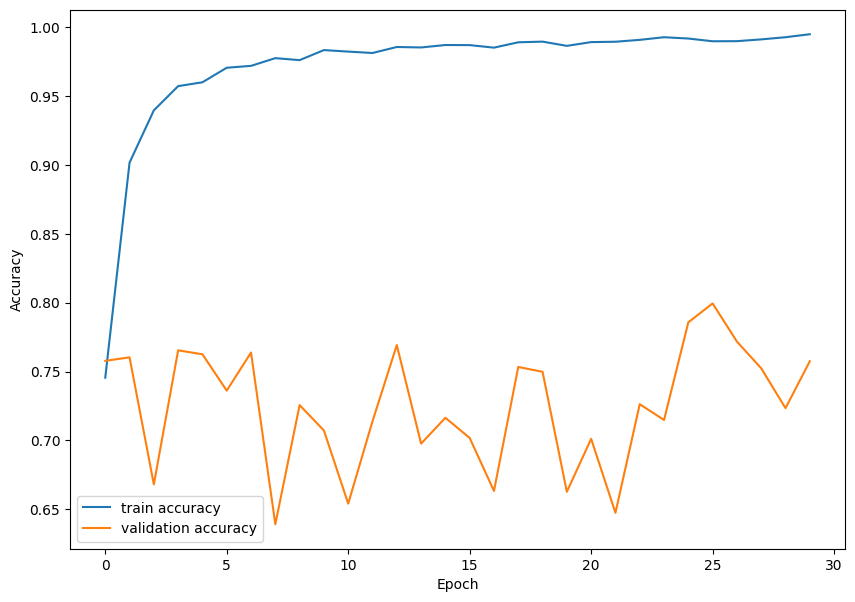

In [176]:
# accuracy 체크
import matplotlib.pyplot as plt

N_EPOCHS = 30 # 에포크 수 정의
history = model_gru # 학습 히스토리 변수 사용

plt.figure(figsize=(10,7))
plt.plot(range(N_EPOCHS), history.history['accuracy'], label='train accuracy')
plt.plot(range(N_EPOCHS), history.history['val_accuracy'], label='validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

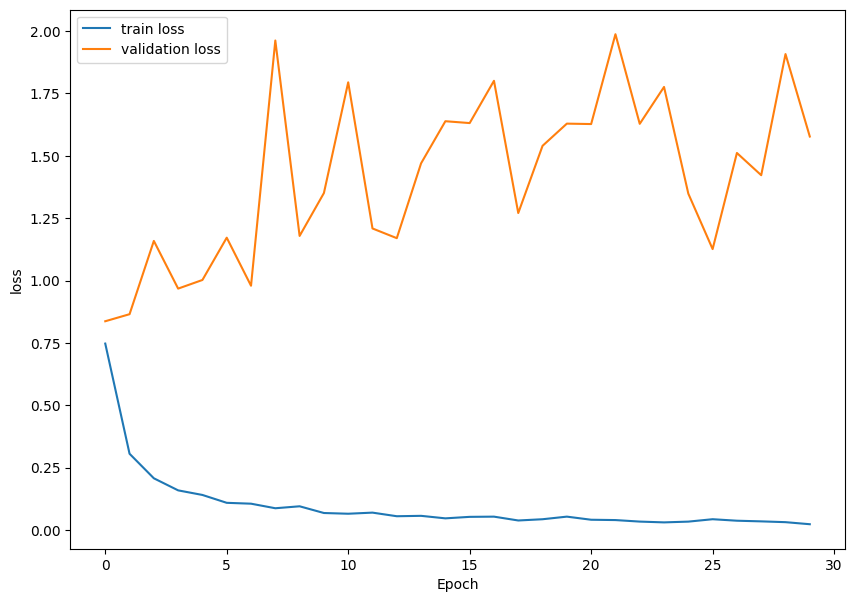

In [177]:
# loss 체크
import matplotlib.pyplot as plt

N_EPOCHS = 30 # 에포크 수 정의
history = model_gru # 학습 히스토리 변수 사용

plt.figure(figsize=(10,7))
plt.plot(range(N_EPOCHS), history.history['loss'], label='train loss')
plt.plot(range(N_EPOCHS), history.history['val_loss'], label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend()
plt.show()